#  Observation models

## Model for Laser Scanners
Scan _z_ consists of _K_ measurements.
$$
z_t = {z^1_t, ... , z^lk_t}
$$
The idividual measurements are independent given the sensor position. _(m is for example a occupancy grid map or a feature map)_
$$
p(z_t\:|\:x_t, m) = \prod^k_{i=1}p(z^i_t\:|\:x_t,m)
$$

<img src="./res/laser_scan.png" alt="laser_scan" width="200"/>

Simplest ray-casting model assumes gaussian noise at the distance. It is often advised to use a more advanced model in order to handle inconsistencies in our assumptions (static world). 

A more advanced ray-cast model can be a mixture of four models: considers different effects (dynamic objects, random, max-range, noise).

### Beam-Based Proximity Model
Can be though of as a mixture of four models.

**Measurement noise**
$$
P_{hit}(z \: | \: x,m) = (2\pi\sigma^2)^{-1/2}\text{exp}(-\frac{1}{2}\frac{(z-z_{exp})^2}{\sigma^2})
$$
**Unexpected obstacles**:
$$
P_{unexp}(z\: | x,m) = \begin{cases}
        \lambda \: \text{exp}(-\lambda z) & z < z_{exp}\\
        0 & \text{otherwise}
        \end{cases}
$$
**Random measurement** 
$$
P_{rand}(z\:|\:x,m) = \text{const.}
$$
**Max range/no return**
$$
P_{max}(z\:|\:x,m) = \begin{cases}
        \text{const.} & z = z_{max} \\
        0 & \text{otherwise}
        \end{cases}
$$
<img src="./res/mixture_model.png" alt="mixture_model" width="300"/>

**How to determine the parameters?** 

Some are easy, some can be measured in a controlled environment. We can also learn paramters from data. 

## Model for perceiving Landmakrs with Range-Bearing Sensors
* Range bearing $z^i_t = (r^i_t, \: \phi^i_t)^T$
* Pose $(x,y,\phi)^T$
* Observation of feature _j_ at location $(m_{j,x},\: m_{j,y})$
$$
(r^i_t,\: \phi^i_t) = (\:\sqrt{(m_{j,x}-x)^2 + (m_{j,y} -y)^2 + Q_t}\:, \: \text{atan2}(m_{j,y}-y,\:m_{j,x}-x) - \phi + Q_t)
$$
* Gaussian noise with covariance $Q_t$ in range and bearing measurement





# Exercise 5: Observation model


## 5.1 Implement model for perceiving landmarks

Consider a robot that operates in an environment populated by **range-only** sensors such as _beacons_.
These sensors transmit a signal that allows for obtaining noisy measurements of their distance from a receiver mounted on the robot.

The function `landmark_observation_model` realizes the observation model for perceiving landmarks with a range sensor. It takes as input:
 
- the observed noisy range $z$
- the standard deviation of the measurement $\sigma_z$ (zero-mean Gaussian noise)
- the position of the robot in the map $x$
- the position of the beacon transmitting beacon in the map $m$

The output of this function is the probability $p(z | x, m)$ that the measurement $z$ was obtained at position $x$.

Implement the `landmark_observation_model` function and verify that it is correct for some test input. **[2.0]**

In [1]:
from src.obs_model import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import numpy as np

In [2]:
x = np.array([0, 3, 3]).T
m = np.array([3, 3])
z = 3
sigma = 0.15


def landmark_observation_model(z, sigma, x, m):
    # Expected range z is the position of transmitted beacon minus the robot location (x,y)
    z_exp = np.sqrt((m[0]-x[0])**2 + (m[1]-x[1])**2)

    # P_hit calculation from measurement noise
    P_hit_exp = np.exp( ((z-z_exp)**2)/(-2*sigma**2) );
    P_hit = (1/np.sqrt(2*math.pi*sigma**2)) * P_hit_exp    
    return P_hit


prob_z = landmark_observation_model(z, sigma, x , m)
prob_z


2.6596152026762176

---

## 5.2 Compute likelihood of measurement in the environment

The robot operates in an environment that is represetend by a 20x20 grid map and contains a beacon at position $m_1 = [0,0]$ (top-left corner). 

The robot obtains a range measurement of the beacon $z_1 = 10$ and the sensor noise is $\sigma_{z1} = 1$.

Compute the `landmark_observation_model` at each cell of the environment and plot the likelihood of the observation over the environment. **[1.0]** 

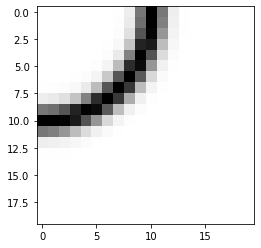

In [3]:

gridmap = np.zeros([20,20]) # Grid is a square, here 20x20
m = np.array([0, 0]) # Beacon at top-left corner
z = 10
sigma = 1

for x in range(20):
    for y in range(20):
        gridmap[x, y] = landmark_observation_model(z, sigma, np.array([x, y]), m)

plot_gridmap(gridmap)


---

## 5.3 Multiple landmarks

Assume that we install two **additional** beacons in our environment:

- $m_2 = [0, 10]$
- $m_3 = [10, 0]$

from which we obtain the following observations:

- $z_2 = 5$ with $\sigma_{z2} = 3$
- $z_3 = 9$ with $\sigma_{z3} = 2$

Compute the `landmark_observation_model` at each cell of the environment considering the measurements from **all** beacons and plot the **joint** likelihood of the observations over the environment. **[2.0]** 

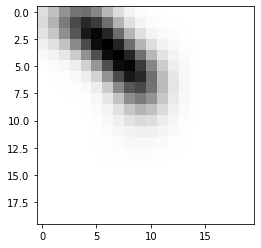

In [4]:
# Input data

m2 = np.array([0,10])
m3 = np.array([10,0])

z2 = 5
sigma2 = 3

z3 = 9
sigma3 = 2

# Calculate joint probabiltiy from multiple landmarks
gridmap = np.zeros([20,20]) # Grid is a square, here 20x20
m = np.array([m2, m3])
z = np.array([z2, z3])
sigma = np.array([sigma2, sigma3])
for x in range(20):
    for y in range(20):
        # Calculate joint probabiltiy for all beacons i
        p_z = 1 
        for i in range(len(m)):
            p_i = landmark_observation_model(z[i], sigma[i], np.array([x, y]), m[i])
            p_z = p_z * p_i
        gridmap[x, y] = p_z
        
plot_gridmap(gridmap)


# Interactive plot

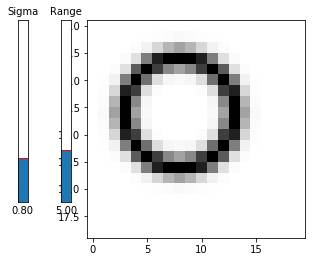

In [6]:
# Uncomment this for interactive plots in jupyter notebook
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# Define initial parameters
m = np.array([8, 8]) # Beacon at top-left corner
init_z = 5 # Range
init_std = 0.8

# Create the figure that we will manipulate
fig, ax = plt.subplots()
gridmap = np.zeros([20,20]) # Grid is a square, here 20x20
def get_grid(z, sigma, m):
    for x in range(20):
        for y in range(20):
            gridmap[x, y] = landmark_observation_model(z, sigma, np.array([x, y]), m)
get_grid(init_z, init_std, m)
ax.imshow(gridmap, cmap='Greys')

# Make a vertically oriented slider to control the amplitude
axstd = plt.axes([0.1, 0.25, 0.0225, 0.63])
std_slider = Slider(
    ax=axstd,
    label="Sigma",
    valmin=0.1,
    valmax=3,
    valinit=init_std,
    orientation="vertical"
)

axz = plt.axes([0.2, 0.25, 0.0225, 0.63])
z_slider = Slider(
    ax=axz,
    label="Range",
    valmin=1,
    valmax=15,
    valinit=init_z,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    get_grid(gridmap, z_slider.val, std_slider.val, m)
    ax.imshow(gridmap, cmap='Greys')
    fig.canvas.draw_idle()

std_slider.on_changed(update)
z_slider.on_changed(update)

plt.show()
